In [1]:
import pandas as pd
import numpy as np
import sys

In [2]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [3]:
data = pd.read_csv('/home/msc2/Desktop/MDSC-301/phones.csv')

In [5]:
data = pd.concat([data], ignore_index = True)

In [6]:
data['rating'].value_counts()

4.0 out of 5 stars    476
5.0 out of 5 stars    275
3.0 out of 5 stars    209
2.0 out of 5 stars     52
1.0 out of 5 stars     49
Name: rating, dtype: int64

In [7]:
data.duplicated().sum()

29

In [8]:
data = data.drop_duplicates()

In [9]:
data['rating'].value_counts()

4.0 out of 5 stars    451
5.0 out of 5 stars    272
3.0 out of 5 stars    208
2.0 out of 5 stars     52
1.0 out of 5 stars     49
Name: rating, dtype: int64

In [10]:
data['rating'] = data['rating'].apply(lambda x: x.split()[0].split('.')[0])

In [11]:
data['rating']

0       4
1       4
2       4
3       4
4       4
       ..
1055    2
1056    4
1057    5
1058    3
1060    3
Name: rating, Length: 1032, dtype: object

In [12]:
data = data.astype({'rating':'int64'})

In [13]:
ndf = data.copy()

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1032 entries, 0 to 1060
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  1032 non-null   object
 1   rating  1032 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 24.2+ KB


In [15]:
data.head()

,review,rating
0,The Mi Dual driver headphones delivers more th...,4
1,"I Brought this earphone 3 days back, After see...",4
2,All over is good but ear fiiting is not well.,4
3,100% Value for money product.\nBASS was awesom...,4
4,Bass quality is good ... Treble sound is good....,4


In [17]:
!pip install imbalanced-learn

     |████████████████████████████████| 199 kB 4.1 MB/s eta 0:00:01
     |████████████████████████████████| 30.8 MB 2.1 MB/s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


In [24]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, LancasterStemmer
import string
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/msc2/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [25]:
def clean(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[""''_]', '', text)
    text = re.sub('\n', '', text)
    return text

def decontract_text(text):
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"won\’t", "will not", text)
    text = re.sub(r"can\’t", "can not", text)
    text = re.sub(r"\'t've", " not have", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'clock", "f the clock", text)
    text = re.sub(r"\'cause", " because", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"n\’t", " not", text)
    text = re.sub(r"\’re", " are", text)
    text = re.sub(r"\’s", " is", text)
    text = re.sub(r"\’d", " would", text)
    text = re.sub(r"\’ll", " will", text)
    text = re.sub(r"\’t", " not", text)
    text = re.sub(r"\’ve", " have", text)
    text = re.sub(r"\’m", " am", text)
    return text

def final_clean(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    stop = set(stopwords.words('english'))
    filtered_words = [word for word in text.split() if word not in stop]
    ps = LancasterStemmer()
    text = [ps.stem(word) for word in filtered_words]
    text = ' '.join(text)
    return text

In [26]:
data['review'] = data['review'].apply(lambda text: decontract_text(text))
data['review'] = data['review'].apply(lambda text: clean(text))
data['review'] = data['review'].apply(lambda text: final_clean(text))

In [27]:
data['review']

0       mi dual driv headphon del expect on aspect bas...
1       brought earphon day back see many review got e...
2                                       good ear fiit wel
3       valu money productbass awesomeno cancel cal bi...
4       bass qual good trebl sound good clear crisp so...
                              ...                        
1055    sound qual good unfortun receiv defect produc ...
1056                     wast produc bet go realm earphon
1057    best earphon rup sound qual excel bass gre pas...
1058                                           nic produc
1060    sound qual expect purchas on piston fit trust ...
Name: review, Length: 1032, dtype: object

In [29]:
vector = CountVectorizer()
X = vector.fit_transform(data["review"])
X

<1032x2791 sparse matrix of type '<class 'numpy.int64'>'
	with 16418 stored elements in Compressed Sparse Row format>

In [30]:
df = pd.DataFrame(X.toarray(),columns=vec.get_feature_names_out())

In [31]:
data['rating'].value_counts()

4    451
5    272
3    208
2     52
1     49
Name: rating, dtype: int64

In [32]:
data['sentiment'] = data['rating'].apply(lambda x: 1 if x>3 else 0)

In [33]:
data

,review,rating,sentiment
0,mi dual driv headphon del expect on aspect bas...,4,1
1,brought earphon day back see many review got e...,4,1
2,good ear fiit wel,4,1
3,valu money productbass awesomeno cancel cal bi...,4,1
4,bass qual good trebl sound good clear crisp so...,4,1
...,...,...,...
1055,sound qual good unfortun receiv defect produc ...,2,0
1056,wast produc bet go realm earphon,4,1
1057,best earphon rup sound qual excel bass gre pas...,5,1
1058,nic produc,3,0


In [34]:
data['sentiment'].value_counts()

1    723
0    309
Name: sentiment, dtype: int64

In [35]:
y = data['sentiment']
Xtrain, Xtest, ytrain, ytest = train_test_split(df,y,test_size=0.3, stratify = y)
print(ytrain.value_counts())
print(ytest.value_counts())

1    506
0    216
Name: sentiment, dtype: int64
1    217
0     93
Name: sentiment, dtype: int64


In [36]:
print(Xtrain.shape, Xtest.shape)
print(ytrain.shape, ytest.shape)

(722, 2791) (310, 2791)
(722,) (310,)


In [44]:
def print_acc(Ptrain,Ptest,ytrain,ytest):
    print(f'|Accuracy \n| {classification_report(ytrain, Ptrain)} |')


def gen_conf(actual,pred):
    classes = [0,1]
    cm = confusion_matrix(actual,pred, labels=classes)
    sn.heatmap(cm, annot=True)
    plt.title("Confusion matrix")
    plt.show()

|Accuracy 
|               precision    recall  f1-score   support

           0       0.83      0.88      0.85       216
           1       0.95      0.92      0.94       506

    accuracy                           0.91       722
   macro avg       0.89      0.90      0.89       722
weighted avg       0.91      0.91      0.91       722
 |


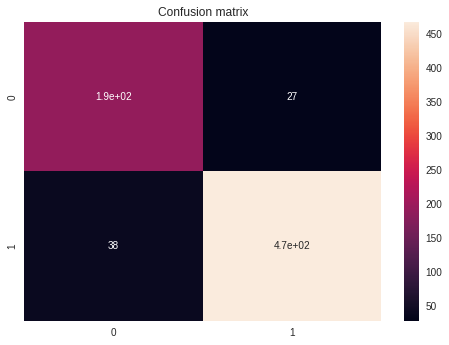

In [45]:
clf = svm.SVC(class_weight = 'balanced')
clf.fit(Xtrain, ytrain)
trpred = clf.predict(Xtrain)
tpred = clf.predict(Xtest)
print_acc(trpred, tpred, ytrain, ytest)
gen_conf(ytrain, trpred)

|Accuracy 
|               precision    recall  f1-score   support

           0       1.00      0.11      0.20       216
           1       0.72      1.00      0.84       506

    accuracy                           0.73       722
   macro avg       0.86      0.56      0.52       722
weighted avg       0.81      0.73      0.65       722
 |


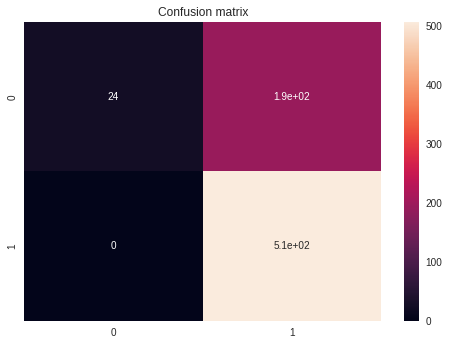

In [47]:
rfc = RandomForestClassifier(n_jobs = -1, max_depth = 10, n_estimators = 50)
rfc.fit(Xtrain, ytrain)
trpred = rfc.predict(Xtrain)
tpred = rfc.predict(Xtest)
print_acc(trpred, tpred, ytrain, ytest)
gen_conf(ytrain, trpred)